In [48]:
import tensorflow as tf
#import tensorflow.keras as tfk
import pandas as pd
import numpy as np
%matplotlib inline

In [49]:
data = pd.read_csv("ts_hr_feb_2020.csv.zip", parse_dates=['date'])

In [50]:
data.head()

,date,sales_value
0,2020-02-01 00:00:00,28.60
1,2020-02-01 01:00:00,122.84
2,2020-02-01 02:00:00,112.87
3,2020-02-01 03:00:00,357.20
4,2020-02-01 04:00:00,642.56


In [14]:
?tf.keras.layers.Conv1D

Init signature:
tf.keras.layers.Conv1D(
    filters,
    kernel_size,
    strides=1,
    padding='valid',
    data_format='channels_last',
    dilation_rate=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
1D convolution layer (e.g. temporal convolution).

This layer creates a convolution kernel that is convolved
with the layer input over a single spatial (or temporal) dimension
to produce a tensor of outputs.
If `use_bias` is True, a bias vector is created and added to the outputs.
Finally, if `activation` is not `None`,
it is applied to the outputs as well.

When using this layer as the first layer in a model,
provide an `input_shape` argument
(tuple of integers or `None`, e.g.
`(10, 128)` for sequences of 10 vectors of 128-dimensional vectors,
or `(

In [52]:
numerical_i = tf.keras.layers.Input((24, 1))
numerical = tf.keras.layers.Conv1D(10, 3)(numerical_i)
numerical = tf.keras.layers.Flatten()(numerical)
dense = tf.keras.layers.Dense(200, 'relu')(numerical)
out = tf.keras.layers.Dense(24, 'relu')(dense)

mdl = tf.keras.Model(numerical_i, out)
mdl.compile('adam', 'mae')
mdl.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 10)            40        
_________________________________________________________________
flatten_3 (Flatten)          (None, 220)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               44200     
_________________________________________________________________
dense_7 (Dense)              (None, 24)                4824      
Total params: 49,064
Trainable params: 49,064
Non-trainable params: 0
_________________________________________________________________


In [16]:
last_sunday = pd.to_datetime("2020-02-23")
train = data[data['date'] < last_sunday]
val = data[data['date'] >= last_sunday]

In [60]:
l = 24
h = 24

X = []
Y = []
for i in range(l,train.shape[0]-h):
    f = train.iloc[i-l:i]['sales_value'].values #hoje
    y = train.iloc[i:i+h]['sales_value'].values # 1 dia depois
    
    X.append(f)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)

X = np.expand_dims(X, -1)
#Y = np.expand_dims(Y, -1)

In [61]:
X.shape

(479, 24, 1)

In [62]:
Y.shape

(479, 24)

In [63]:
mdl.fit(X, Y, batch_size=1, shuffle=True, epochs=5)

Train on 479 samples
Epoch 1/5
479/479 [==============================] - 2s 4ms/sample - loss: 680.6287
Epoch 2/5
479/479 [==============================] - 1s 2ms/sample - loss: 510.0402
Epoch 3/5
479/479 [==============================] - 1s 2ms/sample - loss: 498.1314
Epoch 4/5
479/479 [==============================] - 1s 2ms/sample - loss: 486.7407
Epoch 5/5
479/479 [==============================] - 1s 2ms/sample - loss: 477.3544


In [64]:
Xv = []
Yv = []
for i in range(l,val.shape[0]-h):
    f = val.iloc[i-l:i]['sales_value'].values #hoje
    y = val.iloc[i:i+h]['sales_value'].values # 1 dia depois
    
    Xv.append(f)
    Yv.append(y)

Xv = np.array(Xv)
Yv = np.array(Yv)

Xv = np.expand_dims(Xv, -1)
#Y = np.expand_dims(Y, -1)

In [65]:
p = mdl.predict(Xv)

In [66]:
Yv.shape

(121, 24)

In [67]:
p.shape

(121, 24)

In [68]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Yv, p)

473.82915115421474

In [41]:
p_base = np.ones(Yv.shape)*np.median(Y, axis=0)

In [69]:
p_base

array([[1864.34, 1864.34, 1864.34, ..., 1816.54, 1807.54, 1807.54],
       [1864.34, 1864.34, 1864.34, ..., 1816.54, 1807.54, 1807.54],
       [1864.34, 1864.34, 1864.34, ..., 1816.54, 1807.54, 1807.54],
       ...,
       [1864.34, 1864.34, 1864.34, ..., 1816.54, 1807.54, 1807.54],
       [1864.34, 1864.34, 1864.34, ..., 1816.54, 1807.54, 1807.54],
       [1864.34, 1864.34, 1864.34, ..., 1816.54, 1807.54, 1807.54]])

In [70]:
mean_absolute_error(Yv, p_base)

829.0155612947652

In [140]:
# 447.9483532096762 - 1
# 389.7420670383758 - 2
# 412.0128835990081 - 4
# 440.49684000899623 - 8

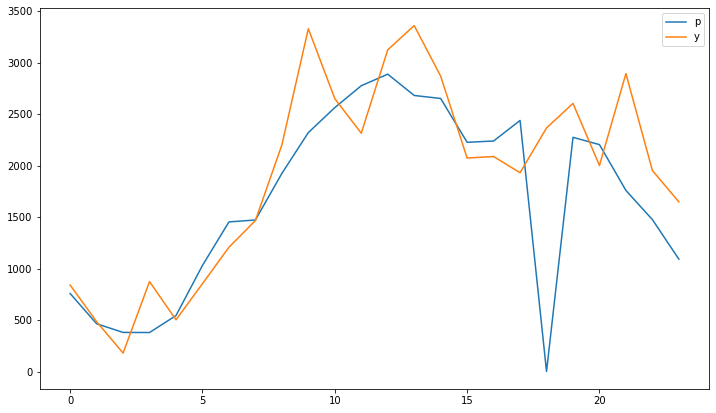

In [71]:
pd.DataFrame({'p': p[71,:], 'y': Yv[71,:]}).plot(figsize=(12,7))